# monoculture

In [1]:
import cometspy as c
import os
import pandas as pd
import matplotlib.pyplot as plt
import cobra

In [21]:
#diet
diet = pd.read_csv('Magnusdottir_2017_TableS12_diets.csv')
diet.head()

,metabolite_ID,Exchange_reaction,metabolite_name,western,high_fiber
0,arab_L,EX_arab_L(e),L-arabinose,0.178783,0.047368
1,cellb,EX_cellb(e),Cellobiose,0.074493,0.019737
2,drib,EX_drib(e),2-deoxy-D-ribose,0.178783,0.047368
3,fru,EX_fru(e),D-Fructose,0.148986,0.039474
4,fuc_L,EX_fuc_L(e),L-fucose,0.148986,0.039474


In [ ]:
diet_dict = {}  

In [9]:
# model to store the models

models_dir = "models20"
model_files = sorted(os.listdir(models_dir))

models_meta = {} # id: name
models = {} # id: model
#comets_models = {} # id: comets model
for i in range(5):
    model_name = model_files[i].split(".")[0]
    model_path = os.path.join(models_dir, model_files[i])
    models_meta[i] = model_name
    #print('loading', model_name, '...')
    model = cobra.io.read_sbml_model(model_path) 
    models[i] = model
    #comets_model = c.model(model)

print('Done loading the models!')


Done loading the models!


In [11]:
initial_pop = 1.e-3 # gDW

# make COMETS models from the cobrapy models - sample run
model1 = c.model(models[0])
model2 = c.model(models[1])

model1.id = 'model1'
model2.id = 'model2'

model1.initial_pop = [0,0,initial_pop] # x, y, gDW
model2.initial_pop = [0,0,initial_pop] # x, y, gDW

model1.open_exchanges()
model2.open_exchanges() 

c:\Users\sabh\Desktop\comets\cometsenv\Lib\site-packages\cometspy\model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.
c:\Users\sabh\Desktop\comets\cometsenv\Lib\site-packages\cometspy\model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


In [14]:
## NOTE: cobrapy media are set using exchange reaction IDs, whereas COMETS media are set using metabolite ids - use a dictionary 

# setup layout by providing models
layout = c.layout([model1, model2])

In [36]:
for met in diet['metabolite_ID']:
    metabolite = (met+'[e]')
    conc = diet[diet['metabolite_ID'] == met]['western'].values[0]
    #print(metabolite, conc)
    layout.set_specific_metabolite(metabolite, conc) 

In [12]:
#params
'''
# timeStep(hour) - 1.0 #The amount of time between two consecutive simulation updates
# spaceWidth(cm) - 0.1 #Width of one side of the 3d box in the 2D or 3D grid. Therefore, volume of a box = spaceWidth^3. Warning: this value matters for molarity calculations
# maxCycles(steps) - unlimited #number of DFBA iterations (steps) for the simulation. 
The total simulation time will be timeStep * maxCycles.  
# deathRate(fraction/timepoint) - 0.1 #The rate of biomass removal per time step.  
# maxSpaceBiomass(gr) - 10 #Maximum biomass allowed in one grid box.  
# minSpaceBiomass(gr) - 1e-10 Minimum biomass in one grid box not considered zero.  
# cellSize(gr) - 4.3e-13 Grams in one cell. Relevant in simulations with serial dilutions or mutations.
# exchangeStyle(Standard FBA, Monod Style, Pseudo-Monod Style) - Standard FBA #The uptake function for the exchange reactions.  
# defaultVmax(mmol (gCDW)-1 (hour)-1) - 10 #Default maximum uptake rate of a metabolite for the Monod Style exchange. This overrides exchange reaction boundaries with greater magnitude, when using Monod updating.  
# defaultKm(mmol (cm3)-1) - 5 #Default concentration of a metabolite in which uptake is halfmaximal. This value is compared with the metabolite concentration / spaceWidth^3 when computing Monod uptake.  
# defaultHill - 2 #Hill coefficient. Alters the shape of the Monod uptake curve.  
# defaultAlpha(1/(mmol (cm3)-1)) - 1 #The default Alpha coefficient (slope) for the PseudoMonod style exchange.  
# defaultW(mmol (gCDW)-1 (hour)-1) - 10 #The default W coefficient (plateau) for the PseudoMonod style exchange.  
# minConcentration(mmol (cm3)-1) - 1e-26 #Minimal concentration of metabolites in the media.
# numRunThreads - 1 #If >1, allow multithreaded computation. The number of threads to run in parallel.  
# numDiffPerStep - 10 #Number of substeps of media diffusion per biomass update step.  
# allowCellOverlap - FALSE #If true, allows different species to occupy the same space.
'''

'\n# timeStep(hour) - 1.0 #The amount of time between two consecutive simulation updates\n# spaceWidth(cm) - 0.1 #Width of one side of the 3d box in the 2D or 3D grid. Therefore, volume of a box = spaceWidth^3. Warning: this value matters for molarity calculations\n# maxCycles(steps) - unlimited #number of DFBA iterations (steps) for the simulation. \nThe total simulation time will be timeStep * maxCycles.  \n# deathRate(fraction/timepoint) - 0.1 #The rate of biomass removal per time step.  \n# maxSpaceBiomass(gr) - 10 #Maximum biomass allowed in one grid box.  \n# minSpaceBiomass(gr) - 1e-10 Minimum biomass in one grid box not considered zero.  \n# cellSize(gr) - 4.3e-13 Grams in one cell. Relevant in simulations with serial dilutions or mutations.\n# exchangeStyle(Standard FBA, Monod Style, Pseudo-Monod Style) - Standard FBA #The uptake function for the exchange reactions.  \n# defaultVmax(mmol (gCDW)-1 (hour)-1) - 10 #Default maximum uptake rate of a metabolite for the Monod Style e

In [39]:
# chemostat conditions/ parameters
dilution_rate = 0.1 # /hr

for met in layout.media['metabolite']:
    initconc = layout.media[layout.media['metabolite'] == met]['init_amount'].values[0]
    refreshrate = initconc*dilution_rate
    layout.set_specific_refresh(met, refreshrate)

In [75]:
#chemostat

com_params = c.params()
com_params.set_param('deathRate', dilution_rate)
com_params.set_param('metaboliteDilutionRate', dilution_rate)

com_params.set_param("spaceWidth", 0.1)
com_params.set_param("defaultVmax", 20.) #vmax = 20 mmol gDW-1h-1 for all metabolites
com_params.set_param("defaultKm", 0.05) #km = 0.05 mmol

com_params.set_param('timeStep', 0.1) #hours - The amount of time between two consecutive simulation updates
com_params.set_param('maxSpaceBiomass', 10.) #gDW
com_params.set_param('maxCycles', 300) #duration of simulation in timesteps - number of simulation cycles

#save media and flux data
com_params.set_param('writeFluxLog', True)
com_params.set_param('writeMediaLog', True)
com_params.set_param('FluxLogRate', 1)
com_params.set_param('MediaLogRate', 1)


'''
#evo_params.all_params['maxCycles'] = 2400            # simulate 10 serial transfers of 24h each (timeStep = 0.1)

evo_params.all_params['evolution'] = True
evo_params.all_params['mutRate'] = 1e-8             # 
evo_params.all_params['cellSize'] = 1e-10           # cellSize should always be larger than minSpaceBiomass
evo_params.all_params['minSpaceBiomass'] = 1e-11    # make sure it is smaller than cell size!
evo_params.all_params['BiomassLogRate'] = 1

com_params.set_param('timeStep', 0.1) #hrs - 
com_params.set_param('maxCycles', 100) #
'''

com_params.set_param('writeTotalBiomassLog', True) #save to output if True
com_params.set_param('writeBiomassLog', True) #save to output if True

com_params.show_params()

,VALUE,UNITS
BiomassLogName,biomass,
BiomassLogRate,1,cycles
FluxLogName,flux_out,
FluxLogRate,1,cycles
MediaLogName,media_out,
...,...,...
writeBiomassLog,True,logical
writeFluxLog,True,logical
writeMediaLog,True,logical
writeSpecificMediaLog,False,logical


In [76]:
# simulation
simulation = c.comets(layout, com_params)

In [77]:
import time

start_time = time.time()

simulation.run()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Running COMETS simulation ...

Debug Here ...
Done!
Execution time: 29.452839136123657 seconds


In [78]:
simulation.biomass

,cycle,x,y,species,biomass
0,0,0,0,model1,0.001000
1,0,0,0,model2,0.001000
2,1,0,0,model1,0.002057
3,1,0,0,model2,0.004050
4,2,0,0,model1,0.004717
...,...,...,...,...,...
597,298,0,0,model2,0.112933
598,299,0,0,model1,0.016489
599,299,0,0,model2,0.111823
600,300,0,0,model1,0.016345


Text(0, 0.5, 'biomass (gDW)')

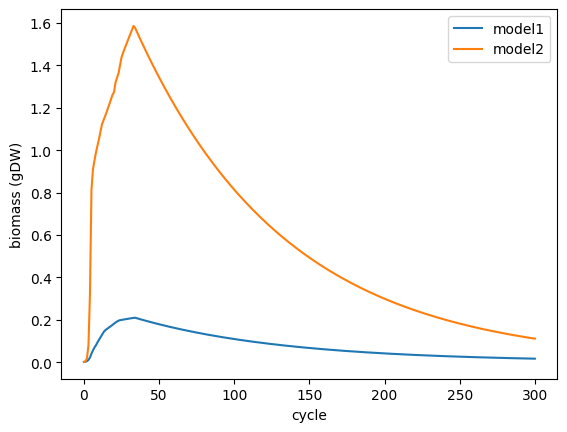

In [46]:
simulation.total_biomass.plot(x = 'cycle')
plt.ylabel('biomass (gDW)')

In [49]:
simulation.total_biomass

,cycle,model1,model2
0,0,0.001000,0.001000
1,1,0.002057,0.004050
2,2,0.004717,0.017848
3,3,0.010342,0.078650
4,4,0.021413,0.319738
...,...,...,...
296,296,0.016932,0.115185
297,297,0.016783,0.114053
298,298,0.016636,0.112933
299,299,0.016489,0.111823


In [52]:
simulation.get_metabolite_time_series()

metabolite,cycle,12dgr180[e],12ppd_S[e],26dap_M[e],2dmmq8[e],2obut[e],3mop[e],4abz[e],4hbz[e],C02528[e],...,tyr_L[e],ura[e],urea[e],uri[e],val_L[e],xan[e],xyl_D[e],xylan[e],xyluglc[e],zn2[e]
0,0,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.180000,1.000000,0.178783,0.000032,0.000013,1.000000
1,1,0.990000,0.011979,0.990000,0.990000,1.0,1.0,1.0,1.0,0.010000,...,0.998020,0.999690,0.010000,0.999182,0.185769,0.999767,0.185016,0.010000,0.010013,0.999968
2,2,0.980100,0.021860,0.980100,0.980100,1.0,1.0,1.0,1.0,0.027880,...,0.993966,0.999467,0.019900,0.996718,0.184761,0.999183,0.185148,0.019886,0.019913,0.999841
3,3,0.970299,0.031641,0.970299,0.970299,1.0,1.0,1.0,1.0,0.049402,...,0.984687,0.998688,0.029701,0.981358,0.155184,0.997951,0.157967,0.029040,0.029714,0.999327
4,4,0.960596,0.041325,0.960596,0.960596,1.0,1.0,1.0,1.0,0.068808,...,0.964364,0.996344,0.039404,0.917746,0.010190,0.995528,0.010710,0.030844,0.039417,0.997377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,296,0.051053,1.895501,0.051053,0.051053,1.0,1.0,1.0,1.0,1.168659,...,0.654806,0.997281,0.948947,0.077235,18.221982,0.997791,0.010000,0.010000,0.948948,0.998979
297,297,0.050542,1.896446,0.050542,0.050542,1.0,1.0,1.0,1.0,1.166973,...,0.658252,0.997308,0.949458,0.086459,18.215439,0.997813,0.010000,0.010000,0.949459,0.998989
298,298,0.050037,1.897382,0.050037,0.050037,1.0,1.0,1.0,1.0,1.165303,...,0.661663,0.997335,0.949963,0.095592,18.208962,0.997835,0.010000,0.010000,0.949964,0.998999
299,299,0.049536,1.898308,0.049536,0.049536,1.0,1.0,1.0,1.0,1.163650,...,0.665040,0.997362,0.950464,0.104633,18.202549,0.997857,0.010000,0.010000,0.950464,0.999009


In [71]:
model1_flux = simulation.get_species_exchange_fluxes('model1', threshold=5.0)

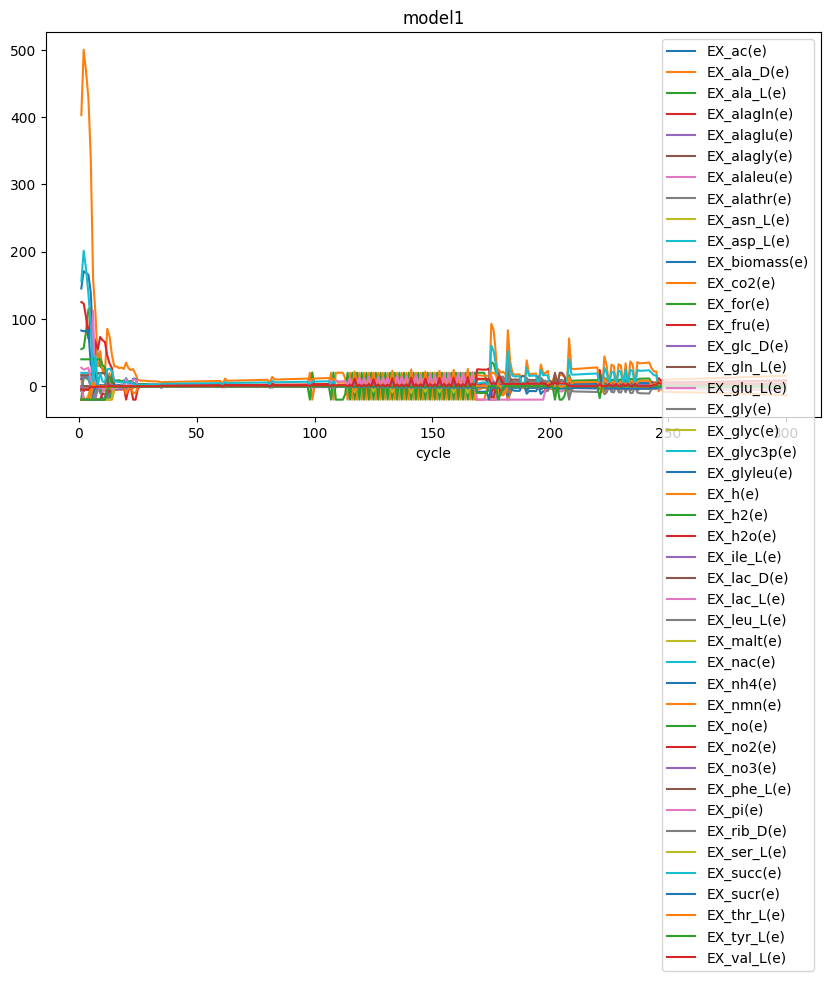

In [74]:
plt.rcParams['figure.figsize'] = (10,5)
model1_flux.plot(x='cycle', title='model1')
plt.show()


In [ ]:
media = simulation.get_metabolite_time_series(upper_threshold = 900.)
media.plot(x = 'cycle')
plt.ylabel('mmol')